<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/word_embeddings_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xmltodict

import os
import io   
import re
import json
import math
import pickle
import string
import tarfile
import xmltodict
import numpy as np
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [10]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [11]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [12]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']

In [13]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [14]:
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [16]:
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

# preprocessing
# case folding
# punctuation removal
# number deletion
# stemming & stopword removal
def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  #s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw and word != 'nan'])
  return s

### `contents` is a dictionary with document id keys and f'{document title} {document content}' values.
```
document_id: f'{document_title} {document_content}'
```

In [17]:
################################################## WORD EMBEDDINGS ##########################################################

In [18]:
!python3 -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [19]:
import spacy

# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')

In [20]:
nlp_stripped = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner', 'entity_linker', 'entity_ruler', 'textcat', 'lemmatizer', 'morphologizer', 'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer'])

In [21]:
%%time
docx = nlp_stripped('i will only be parsed')

CPU times: user 401 µs, sys: 0 ns, total: 401 µs
Wall time: 475 µs


In [22]:
%%time
docy = nlp('i will only be parsed')

CPU times: user 17.1 ms, sys: 127 µs, total: 17.2 ms
Wall time: 27.8 ms


In [23]:
# they yield the same vectors
assert np.prod(docx.vector == docy.vector) == 1

In [24]:
# they yield the same vectors
assert np.prod(list(nlp_stripped.pipe(list(contents.values())[:5]))[0].vector == list(nlp.pipe(list(contents.values())[:5]))[0].vector)

In [25]:
preprocessing = False

In [26]:
%%time
if preprocessing:
  preprocessed_contents = list(map(preprocess, contents.values()))
else:
  preprocessed_contents = list(contents.values())

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.9 ms


In [27]:
%%time
if preprocessing:
  preprocessed_topic_contents = list(map(preprocess, topics_dict.values()))
else:
  preprocessed_topic_contents = list(topics_dict.values())

CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 69.4 µs


In [28]:
%%time
doc_content_list = []
doc_content_list = list(nlp_stripped.pipe(preprocessed_contents))

CPU times: user 1min 37s, sys: 17 s, total: 1min 54s
Wall time: 1min 55s


In [29]:
%%time
topic_content_list = []
topic_content_list = list(nlp.pipe(preprocessed_topic_contents))

CPU times: user 318 ms, sys: 50 ms, total: 368 ms
Wall time: 367 ms


In [30]:
%%time
doc_vector_list = list(map(lambda x: x.vector, doc_content_list))
topic_vector_list = list(map(lambda x: x.vector, topic_content_list))

CPU times: user 5min 12s, sys: 2.12 s, total: 5min 14s
Wall time: 5min 14s


In [31]:
len(doc_vector_list[0]), len(topic_vector_list[0])

(300, 300)

In [32]:
rel = df_relevances.copy()
rel

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [33]:
np.hstack([doc_vector_list[0], topic_vector_list[0]]).shape

(600,)

In [79]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances

In [86]:
%%time
cos_sims = cosine_similarity(doc_vector_list, topic_vector_list)
man_dist = manhattan_distances(doc_vector_list, topic_vector_list)
euc_dist = euclidean_distances(doc_vector_list, topic_vector_list)

CPU times: user 4.04 s, sys: 2.5 s, total: 6.54 s
Wall time: 5.59 s


In [44]:
lookup_ck = {
    key: i
    for i, key in enumerate(contents.keys())
}
lookup_tk = {
    int(key): i
    for i, key in enumerate(topics_dict.keys())
}

X_all, y_all     = [], []
X_train, y_train = [], []
X_test, y_test   = [], []

for row in np.array(rel):
  ck_index = lookup_ck[row[1]]
  tk_index = lookup_tk[row[0]]
  x = np.hstack([
    doc_vector_list[ck_index], 
    topic_vector_list[tk_index],
    doc_vector_list[ck_index] - topic_vector_list[tk_index],
    [
      cos_sims[ck_index, tk_index],
      man_dist[ck_index, tk_index],
      euc_dist[ck_index, tk_index],
    ],
  ])
  
  if row[0] % 2:
    X_train.append(x)
    y_train.append(np.array([row[2]/2]))
  else:
    X_test.append(x)
    y_test.append(np.array([row[2]/2]))
  
  X_all.append(x)
  y_all.append(np.array([row[2]/2]))

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_all = np.array(X_all)
y_all = np.array(y_all)

In [35]:
print('train set', X_train.shape, y_train.shape)
print('test set', X_test.shape, y_test.shape)

train set (35894, 600) (35894, 1)
test set (33424, 600) (33424, 1)


In [77]:
%%time 

# first neural network with keras make predictions
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the keras model
model = Sequential()

model.add(Dense(12, input_dim=600, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# fit the keras model on the dataset
history = model.fit(X_train[:], y_train[:], epochs=20, batch_size=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
3590/3590 [==============================] - 8s 2ms/step - loss: 0.1590 - mse: 0.1590 - val_loss: 0.1780 - val_mse: 0.1780
Epoch 2/20
3590/3590 [==============================] - 7s 2ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 0.1747 - val_mse: 0.1747
Epoch 3/20
3590/3590 [==============================] - 7s 2ms/step - loss: 0.1406 - mse: 0.1406 - val_loss: 0.1774 - val_mse: 0.1774
Epoch 4/20
3590/3590 [==============================] - 7s 2ms/step - loss: 0.1388 - mse: 0.1388 - val_loss: 0.1795 - val_mse: 0.1795
Epoch 5/20
3590/3590 [==============================] - 7s 2ms/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 6/20
3590/3590 [==============================] - 8s 2ms/step - loss: 0.1349 - mse: 0.1349 - val_loss: 0.1774 - val_mse: 0.1774
Epoch 7/20
3590/3590 [==============================] - 7s 2ms/step - loss: 0.1374 - mse: 0.1374 - val_loss: 0.1801 - val_mse: 0.1801
Epoch 8/20
3590/3590 [==============================] - 7s 2ms

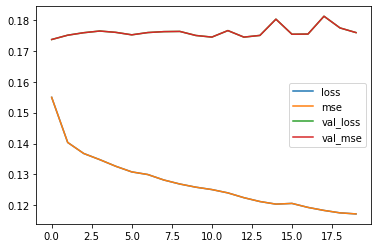

In [76]:
import matplotlib.pyplot as plt

for key, hist in history.history.items():
  plt.plot(hist, label=key)
plt.legend()

In [67]:
# summarize the first 5 cases
mae = 0
l = 100

# make class predictions with the model
predictions = model.predict(X_test[:l])

for i in range(l):
  mae += abs(predictions[i] - y_test[i])
  if not i%10:
    print(f' => {predictions[i]} (expected {y_test[i]})')
print(mae/l)

 => [0.69472003] (expected [1.])
 => [0.37448865] (expected [0.])
 => [0.14610243] (expected [0.])
 => [0.6436872] (expected [0.])
 => [0.2866332] (expected [0.])
 => [0.42179716] (expected [1.])
 => [0.45028865] (expected [0.])
 => [0.28705323] (expected [0.])
 => [0.3868739] (expected [0.])
 => [0.5785826] (expected [0.])
[0.34653035]


In [41]:
len(X_test), len(X_all)

(33424, 69318)

In [45]:
%%time
pred_all = model.predict(X_all)

CPU times: user 1.65 s, sys: 147 ms, total: 1.8 s
Wall time: 1.38 s


In [56]:
rel_nn = np.array(rel)
for i in range(len(rel_nn)):
  rel_nn[i][-1] = pred_all[i][0]
rel_nn

array([[1, '005b2j4b', 0.45848677],
       [1, '00fmeepz', 0.36429635],
       [1, '010vptx3', 0.28393203],
       ...,
       [50, 'zwsvlnwe', 0.44451547],
       [50, 'zxr01yln', 0.24295071],
       [50, 'zz8wvos9', 0.37504572]], dtype=object)

In [64]:
results = []
for i, row in enumerate(rel_nn):
  if not row[0] % 2:
    results.append(f'{row[0]} 0 {row[1]} 0 {row[2]} 0')

In [65]:
results[:10]

['1 0 005b2j4b 0 0.45848676562309265 0',
 '1 0 00fmeepz 0 0.3642963469028473 0',
 '1 0 010vptx3 0 0.28393203020095825 0',
 '1 0 0194oljo 0 0.2632930278778076 0',
 '1 0 021q9884 0 0.11390602588653564 0',
 '1 0 02f0opkr 0 0.3611307144165039 0',
 '1 0 047xpt2c 0 0.6228258609771729 0',
 '1 0 04ftw7k9 0 0.08057340979576111 0',
 '1 0 05qglt1f 0 0.23935788869857788 0',
 '1 0 05vx82oo 0 0.09585243463516235 0']

In [66]:
# Write results to file
with open('results_we_nn_69_nprep_overfit_2.txt', 'w') as f:
    f.write('\n'.join(results))

In [ ]:
############################################ SIMILARITY / DISTANCE #######################################################

In [31]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances

#sims = cosine_similarity(doc_vector_list, topic_vector_list)
#sims = euclidean_distances(doc_vector_list, topic_vector_list)*-1
sims = manhattan_distances(doc_vector_list, topic_vector_list)*-1

CPU times: user 2.28 s, sys: 522 ms, total: 2.8 s
Wall time: 2.81 s


In [32]:
sims.shape

(191175, 50)

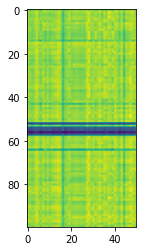

In [33]:
import matplotlib.pyplot as plt
plt.imshow(sims[:100])

In [34]:
all_sims = pd.DataFrame(sims, columns=list(np.array(range(50))+1))
all_sims.insert(loc=0, column='doc_id', value=contents.keys())
all_sims

,doc_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,ug7v899j,-22.892150,-25.777851,-23.105872,-22.120537,-20.463820,-23.943452,-25.331112,-21.360435,-17.358048,-22.615498,-21.908926,-21.976519,-23.499201,-22.663306,-20.773356,-20.309476,-29.168415,-24.664589,-23.834610,-19.083720,-21.822192,-21.053926,-19.286104,-20.101651,-21.997145,-21.283789,-20.399549,-20.874410,-22.259830,-22.134062,-21.353481,-24.835046,-22.419443,-19.805431,-24.274607,-23.537149,-25.978945,-19.920652,-24.066374,-25.691379,-19.278514,-21.247311,-23.920299,-19.831444,-25.743518,-18.726393,-20.787606,-19.585569,-17.713578,-22.434893
1,02tnwd4m,-17.314186,-19.474885,-20.179528,-17.986842,-14.221932,-19.784402,-21.139885,-17.067907,-20.525098,-17.356325,-21.727838,-19.665291,-19.488070,-17.130299,-15.673408,-17.359196,-27.588676,-19.949766,-19.155269,-17.472901,-20.623691,-17.900891,-17.760673,-18.559787,-19.136848,-18.208951,-20.200734,-13.877830,-15.037780,-18.846351,-18.733271,-18.522836,-18.294793,-14.853613,-21.825332,-15.774277,-19.094746,-11.265217,-13.764125,-17.963411,-16.263607,-16.803066,-21.357649,-14.988059,-24.198231,-16.207276,-16.934114,-14.881286,-15.191512,-19.116628
2,ejv2xln0,-21.151809,-22.781486,-21.619737,-21.607797,-15.869118,-23.297888,-21.717959,-22.438938,-23.162451,-22.742689,-24.476722,-22.753685,-22.149481,-21.576031,-17.830555,-20.419110,-30.713510,-23.011262,-20.844317,-16.580560,-23.615778,-20.841543,-20.537752,-21.178777,-22.194480,-21.598982,-22.386184,-19.127080,-14.292782,-22.509845,-22.128969,-17.707399,-22.395253,-20.097150,-25.332754,-17.124834,-21.300090,-15.709538,-19.808954,-18.934989,-20.778215,-19.068961,-25.273457,-19.647452,-28.073511,-20.583341,-21.316093,-19.480464,-15.841467,-22.070071
3,2b73a28n,-20.074424,-22.385052,-21.960632,-21.031420,-16.666689,-22.046277,-22.769520,-19.966341,-19.887853,-20.725210,-21.711954,-21.187352,-22.862425,-20.559999,-17.857241,-20.158454,-27.534702,-23.298487,-21.440309,-17.985879,-21.449683,-17.461739,-19.086002,-19.656553,-19.195516,-19.681643,-21.188686,-16.704918,-17.423879,-18.405540,-20.031606,-19.924136,-21.413301,-18.127018,-24.008763,-19.749054,-21.173185,-12.208979,-16.451122,-18.449897,-19.386865,-16.397051,-22.596552,-18.459889,-24.145783,-17.403746,-19.179681,-18.721911,-17.171211,-20.699903
4,9785vg6d,-19.178845,-19.941123,-19.436324,-20.322310,-14.908190,-20.318660,-17.501116,-20.716472,-19.449913,-20.429056,-19.622858,-19.925184,-19.607507,-19.213037,-17.013651,-20.051065,-27.627272,-21.591117,-19.412195,-15.465175,-20.479899,-17.372509,-17.362757,-17.770112,-17.954982,-18.996697,-20.376150,-18.918336,-13.915267,-20.476695,-18.353101,-15.598622,-18.236388,-18.833610,-21.698214,-18.721464,-20.052908,-13.460852,-18.690320,-14.823727,-19.697835,-19.209680,-23.468777,-17.625732,-26.387749,-19.165747,-18.639001,-18.713277,-14.640151,-18.327145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191170,z4ro6lmh,-28.190382,-28.722186,-25.482290,-27.831838,-25.956084,-24.710983,-26.443739,-25.827025,-26.716767,-28.842063,-25.614225,-25.596957,-29.895257,-28.594042,-27.588678,-26.412928,-31.721613,-27.774430,-27.215632,-26.395269,-30.472618,-24.177700,-25.869744,-26.328303,-25.381986,-23.244141,-27.632320,-23.599171,-26.042057,-23.025172,-27.367927,-31.210062,-27.706928,-24.172700,-31.926669,-27.428205,-28.550579,-23.491641,-24.391469,-27.513299,-28.167346,-24.544356,-30.076843,-26.021460,-28.846772,-23.723908,-26.908770,-27.925093,-24.792458,-26.766946
191171,hi8k8wvb,-19.780420,-22.162298,-24.088242,-21.161539,-15.830519,-22.472384,-23.030744,-22.218842,-26.086116,-21.210847,-25.706605,-23.324374,-21.135855,-19.511572,-17.319165,-18.891091,-30.517929,-23.537991,-21.299599,-19.277930,-23.482377,-23.603896,-22.097486,-22

In [35]:
ours = df_relevances.copy()
ours

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [36]:
c = all_sims.melt(
    id_vars=['doc_id'],
    var_name='topic',
    value_name='similarity',
)

In [37]:
c.columns = ['document_id', 'topic', 'similarity']

In [38]:
new_results = pd.merge(c, df_relevances, left_on=['document_id', 'topic'], right_on=['document_id', 'topic'])

In [39]:
del new_results['judgement']

In [40]:
nae = np.array(new_results)

In [41]:
nae

array([['sw4wtxdk', 1, -17.733252924321278],
       ['6wu024ng', 1, -17.714127253835613],
       ['sbxqwfmy', 1, -17.573692263111298],
       ...,
       ['7g3p570l', 50, -22.12086854779409],
       ['eqfz0wpm', 50, -16.611537000349927],
       ['qyflkmi9', 50, -16.425966546714335]], dtype=object)

In [42]:
results = []
for i, row in enumerate(nae):
  results.append(f'{row[1]} 0 {row[0]} 0 {row[2]} 0')

In [43]:
results[:10]

['1 0 sw4wtxdk 0 -17.733252924321278 0',
 '1 0 6wu024ng 0 -17.714127253835613 0',
 '1 0 sbxqwfmy 0 -17.573692263111298 0',
 '1 0 1rhy8td0 0 -15.191630252746108 0',
 '1 0 t7rxmzvi 0 -20.999028905040177 0',
 '1 0 480d3yfv 0 -23.067925343602838 0',
 '1 0 b66bb2ri 0 -15.161752639389306 0',
 '1 0 sn1a7ikq 0 -21.205071425698407 0',
 '1 0 j7fx64k1 0 -20.205407256491526 0',
 '1 0 5opiip58 0 -17.20253032663095 0']

In [44]:
# Write results to file
with open('results_we_nman_69_nprep.txt', 'w') as f:
    f.write('\n'.join(results))

In [45]:
##################################################### TFIDF ################################################################

In [ ]:
if os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  doc_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "rb"))
  doc_vectorizer = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectorizer.pickle", "rb"))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# fit TfidfVectorizer on documents 
doc_vectorizer = TfidfVectorizer(preprocessor=preprocess)
doc_vectors = doc_vectorizer.fit_transform(list(contents.values()))

print("There are", len(doc_vectorizer.vocabulary_), "tokens in our vocabulary.")

There are 145387 tokens in our vocabulary.


In [ ]:
# Vectorize the topics with the same vectorizer
topic_vectors = doc_vectorizer.transform(list(topics_dict.values()))

In [ ]:
pickle.dump(doc_vectors, open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "wb"))
pickle.dump(doc_vectorizer, open("drive/MyDrive/CMPE/CMPE493/doc_vectorizer.pickle", "wb"))

In [ ]:
# number of documents, length of vector
doc_vectors.shape

(191175, 145387)

In [ ]:
# number of topics, length of vector
topic_vectors.shape

(50, 145387)

In [ ]:
# key: document_id
# val: document's TFIDF vector
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [ ]:
# key: topic_id
# val: topic's TFIDF vector
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(topics_dict.keys())
}

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#Take random doc_id and print most relevant topic
ex_document = df_metadata.sample().cord_uid.to_string().split()[1]
similarity = cosine_similarity(doc_vectors_dict[ex_document],topic_vectors).flatten()

best_sim      = np.max(similarity)
best_topic_id = np.argmax(similarity) + 1

print(f"Example document id: {ex_document}")
print(f"Maximum cosine similarity among all topics: {best_sim:.4f}")
print(f"Argmax of maximum cos. sim.: {best_topic_id}")
print(f"Contents of document '{ex_document}': {contents[ex_document]}")
print(f"Contents of topic '{best_topic_id}': {topics_dict[str(best_topic_id)]}")


Example document id: um607cmb
Maximum cosine similarity among all topics: 0.0379
Argmax of maximum cos. sim.: 4
Contents of document 'um607cmb': Letter: News From the COVID-19 Front Lines: How Neurosurgeons Are Contributing nan
Contents of topic '4': how do people die from the coronavirus what causes death from Covid-19? Studies looking at mechanisms of death from Covid-19.


In [ ]:
sims = cosine_similarity(topic_vectors, doc_vectors)
sims.shape

(50, 191175)

In [ ]:
results = np.ndarray((len(contents)*int(len(topics_dict)/2),1))
results = list(results)

#Even results
for j,topic in enumerate(topics_dict.keys()):
  if(j%2 != 0):
    for i,doc_id in enumerate(contents.keys()):
      element = f'{topic} 0 {doc_id} 0 {sims[j][i]} 0'
      results[int(j/2)*len(contents.keys())+i] = element

**results.csv columns:**
qid, iter, docno, rank, sim, run_id 

In [ ]:
results[:10]

['2 0 ug7v899j 0 0.0 0',
 '2 0 02tnwd4m 0 0.011011974322833466 0',
 '2 0 ejv2xln0 0 0.012277492779388261 0',
 '2 0 2b73a28n 0 0.0 0',
 '2 0 9785vg6d 0 0.06059505130597204 0',
 '2 0 zjufx4fo 0 0.00864037385739897 0',
 '2 0 5yhe786e 0 0.0 0',
 '2 0 8zchiykl 0 0.0 0',
 '2 0 8qnrcgnk 0 0.008868282023550493 0',
 '2 0 jg13scgo 0 0.0035325109038701072 0']

In [ ]:
# Write results to file
with open('results.txt', 'w') as f:
    f.write('\n'.join(results))

In [ ]:
import random

results_random = np.ndarray((len(contents)*int(len(topics_dict)/2),1))
results_random = list(results_random)

#Even results
for j,topic in enumerate(topics_dict.keys()):
  if(j%2 != 0):
    for i,doc_id in enumerate(contents.keys()):
      element = f'{topic} 0 {doc_id} 0 {random.random()} 0'
      results_random[int(j/2)*len(contents.keys())+i] = element

In [ ]:
# Write results to file
with open('results_random.txt', 'w') as f:
    f.write('\n'.join(results_random))

In [ ]:
import random

results_random = np.ndarray((len(contents)*int(len(topics_dict)/2),1))
results_random = list(results_random)

#Even results
for j,topic in enumerate(topics_dict.keys()):
  if(j%2 != 0):
    for i,doc_id in enumerate(contents.keys()):
      element = f'{topic} 0 {doc_id} 0 {random.random()} 0'
      results_random[int(j/2)*len(contents.keys())+i] = element

In [22]:
rd = df_relevances.copy()
rd['judgement'] = np.random(np.array(rd['judgement']).shape)

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1
